In [1]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from sklearn import datasets
from sklearn.semi_supervised import label_propagation
from sklearn.metrics import classification_report, confusion_matrix


Automatically created module for IPython interactive environment


In [2]:
digits = datasets.load_digits()
rng = np.random.RandomState(0)
indices = np.arange(len(digits.data))
rng.shuffle(indices)

In [5]:
X = digits.data[indices[:330]]
y = digits.target[indices[:330]]
images = digits.images[indices[:330]]
n_total_samples = len(y)
n_labeled_points = 10

unlabeled_indices = np.arange(n_total_samples)[n_labeled_points:]


Iteration 0 ______________________________________________________________________
Label Spreading model: 10 labeled & 320 unlabeled (330 total)
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        24
          1       0.49      0.90      0.63        29
          2       0.88      0.97      0.92        31
          3       0.00      0.00      0.00        28
          4       0.00      0.00      0.00        27
          5       0.89      0.49      0.63        35
          6       0.86      0.95      0.90        40
          7       0.75      0.92      0.83        36
          8       0.54      0.79      0.64        33
          9       0.41      0.86      0.56        37

avg / total       0.52      0.63      0.55       320

Confusion Matrix
[[26  1  0  0  1  0  1]
 [ 1 30  0  0  0  0  0]
 [ 0  0 17  6  0  2 10]
 [ 2  0  0 38  0  0  0]
 [ 0  3  0  0 33  0  0]
 [ 7  0  0  0  0 26  0]
 [ 0  0  2  0  0  3 32]]


/home/aman/ml/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 1 ______________________________________________________________________
Label Spreading model: 15 labeled & 315 unlabeled (330 total)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        23
          1       0.61      0.59      0.60        29
          2       0.91      0.97      0.94        31
          3       1.00      0.56      0.71        27
          4       0.79      0.88      0.84        26
          5       0.89      0.46      0.60        35
          6       0.86      0.95      0.90        40
          7       0.97      0.92      0.94        36
          8       0.54      0.84      0.66        31
          9       0.70      0.81      0.75        37

avg / total       0.82      0.80      0.79       315

Confusion Matrix
[[23  0  0  0  0  0  0  0  0  0]
 [ 0 17  1  0  2  0  0  1  7  1]
 [ 0  1 30  0  0  0  0  0  0  0]
 [ 0  0  0 15  0  0  0  0 10  2]
 [ 0  3  0  0 23  0  0  0  0  0]
 [ 0  0  0  0  1 16  6  0  2 10]
 

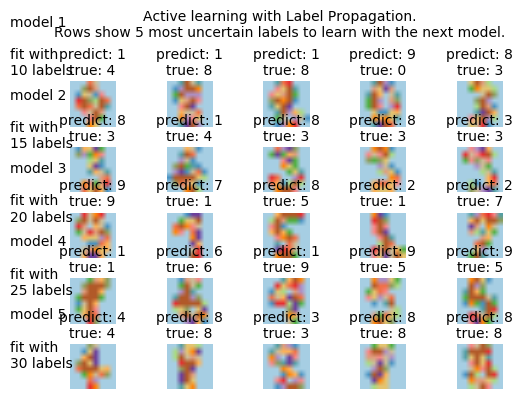

In [7]:
f = plt.figure()
for i in range(5):
    y_train = np.copy(y)
    y_train[unlabeled_indices] = -1
    lp_model = label_propagation.LabelSpreading(gamma=0.25, max_iter=5)
    lp_model.fit(X, y_train)
    
    predicted_labels = lp_model.transduction_[unlabeled_indices]
    true_labels = y[unlabeled_indices]
    
    cm = confusion_matrix(true_labels, predicted_labels, labels=lp_model.classes_)
    
    print('Iteration %i %s' % (i, 70 * '_'))
    print("Label Spreading model: %d labeled & %d unlabeled (%d total)"
          % (n_labeled_points, n_total_samples - n_labeled_points, n_total_samples))

    print(classification_report(true_labels, predicted_labels))
    
    print("Confusion Matrix")
    print(cm)
    
    pred_entropies = stats.distributions.entropy(
        lp_model.label_distributions_.T)
    
    uncertainty_index = np.argsort(pred_entropies)[-5:]
    
    delete_indices = np.array([])
    
    f.text(.05, (1 - (i + 1) * .183),
           "model %d\n\nfit with\n%d labels" % ((i + 1), i * 5 + 10), size=10)
    for index, image_index in enumerate(uncertainty_index):
        image = images[image_index]
        
        sub = f.add_subplot(5, 5, index + 1 + (5 * i))
        sub.imshow(image, cmap=plt.cm.Paired)
        sub.set_title('predict: %i\ntrue: %i' % (
            lp_model.transduction_[image_index], y[image_index]), size=10)
        sub.axis("off")
        
        # labelling 5 points, remote from labeled set
        delete_index, = np.where(unlabeled_indices == image_index)
        delete_indices = np.concatenate((delete_indices, delete_index))
        
    unlabeled_indices = np.delete(unlabeled_indices, delete_indices)
    n_labeled_points += 5
    
f.suptitle("Active learning with Label Propagation.\nRows show 5 most "
           "uncertain labels to learn with the next model.")
plt.subplots_adjust(0.12, 0.03, 0.9, 0.8, 0.2, 0.45)
plt.show()